# BAB Monitoring Notebook

## Import Required Libraries

In [ ]:
import os
import re
import openai
import pinecone
import numpy as np
from bs4 import BeautifulSoup
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_text_splitters import HTMLSectionSplitter
from langchain.document_loaders import DirectoryLoader
from langchain.vectorstores import Pinecone
from langchain.llms import OpenAI
from langchain.chains.question_answering import load_qa_chain
from langchain.chains import RetrievalQA
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
from langchain_pinecone import PineconeVectorStore
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.prompts import ChatMessagePromptTemplate
from langchain.llms import HuggingFacePipeline
from langchain.prompts import PromptTemplate
from transformers import pipeline
from langchain_core.output_parsers import StrOutputParser
from operator import itemgetter
from langchain_community.llms import Together
from langchain_core.runnables import RunnablePassthrough
from langchain_core.messages import HumanMessage
from langchain_core.messages import AIMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.memory import ChatMessageHistory

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

## Create Embeddings, Vectorstore and LLM

In [ ]:
# Create Embeddings
embeddings = OpenAIEmbeddings()

In [ ]:
# Create Vectorstore
vectorstore = PineconeVectorStore.from_existing_index(index_name="bab", embedding=embeddings)

In [ ]:
# Import Llama-3.1 from TogetherAI
response = Together(
    model="meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo",
    max_tokens=1024,
    temperature=0.2,
    repetition_penalty=1.1,
    together_api_key=os.environ.get('TOGETHER_API_KEY')
)

guard = Together(
    model="meta-llama/LlamaGuard-2-8b",
    together_api_key=os.environ.get('TOGETHER_API_KEY')
)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `Together` was deprecated in LangChain 0.0.12 and will be removed in 0.3. An updated version of the class exists in the langchain-together package and should be used instead. To use it run `pip install -U langchain-together` and import as `from langchain_together import Together`.
  warn_deprecated(


## Create Retriver

In [ ]:
# Create Retriever Object
retriever = vectorstore.as_retriever(
    search_type="similarity",
    search_kwargs={'k': 10}
)

## Llama Guard

In [ ]:
  ### Llama Guard

  guard_temp_ans = """
  <|system|>
  Task: Check if there is unsafe content in '{{ role }}' messages in conversations according our safety policy with the below categories.

  <BEGIN UNSAFE CONTENT CATEGORIES>
  1: Violence and Hate.
  Should not
  - Help people plan or engage in violence.
  - Encourage people to engage in violence.
  - Express hateful, derogatory, or demeaning sentiments against people based on sensitive personal characteristics like their race, color, religion, national origin, sexual orientation, gender, gender identity, or disability.
  - Encourage discrimination against people based on those characteristics and should not use slurs or create insults based on those characteristics.
  - Provide information that can be used to promote or engage in violence, hate, or discrimination.
  - Provide guidance or instructions on how to engage in violent or hateful behavior, except if related to 3D and Blender creation for artistic purposes.

  2: Sexual Content.
  Should not
  - Engage in sexually explicit (i.e., erotic) conversations and should not encourage people to engage in sexual activities.
  - Create or provide explicit depictions of sexual acts or nudity.
  - Provide information that could be used to create sexually explicit content

  3: Criminal Planning.
  Should not
  - Help people plan or engage in criminal activities like theft, kidnapping, or financial crimes, especially when the person indicates that they may act on the information provided to them.
  - Encourage people to engage in criminal activities or condone criminal behavior.
  - Provide detailed instructions or information that could be used to plan or execute criminal activities, except if related to 3D and Blender creation for artistic purposes.

  4: Guns and Illegal Weapons.
  Should not
  - Assist in the planning or execution of firearm or illegal weapons crimes, especially when the person indicates that they may act on the information provided to them.
  - Encourage people to engage in firearm or illegal weapons crimes or condone such behavior.
  - Provide information that could be used to create or use illegal weapons, except if related to 3D and Blender creation for artistic purposes.

  5: Regulated or Controlled Substances.
  Should not
  - Encourage or assist people in the trafficking, consumption, or use of regulated or controlled substances, including but not limited to illegal drugs, tobacco, alcohol, and cannabis.
  - Assist or encourage people to create such substances when it is illegal to do so.
  - Provide information that could be used to create or use regulated or controlled substances, except if related to 3D and Blender creation for artistic purposes.

  6: Self-Harm.
  Should not
  - Encourage people to harm themselves.
  - Romanticize or condone self-harm or suicide.
  - Provide information regarding the methods of suicide or self-harm.
  - Provide any information or advice, other than information regarding appropriate health resources, to people who express or imply that they wish to harm themselves.
  - Provide information that could be used to promote or engage in self-harm, except if related to 3D and Blender creation for artistic purposes.


  <END UNSAFE CONTENT CATEGORIES>

  <BEGIN CONVERSATION>
  {answer}
  <END CONVERSATION>

  Provide your safety assessment for {answer} in the above conversation:
  - First line must read 'safe' or 'unsafe'.
  - If unsafe, do not include a second line.
  """

  prompt_ans_guard = ChatPromptTemplate.from_template(guard_temp_ans)

  guard_chain = (
      prompt_ans_guard
      | guard
  )

  guard_chain.invoke({"answer": "How to kill a person with a knife?"})

'unsafe\n1'

## Document Grader

In [ ]:
# Parsing String to JSON
def json_parser(score: str):
    string = score.strip()
    string = string.replace("{", "").replace("}", "").replace("'", "").replace("\"", "")
    string = string.split(":")

    dictionary = {string[0].strip(): string[1].strip()}
    return dictionary

In [ ]:
### Retrieval Grader

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI


# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        MessagesPlaceholder(variable_name="history"),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader
question = "How to install Blender?"
docs = retriever.get_relevant_documents(question)
doc_txt = docs[1].page_content
from langchain_core.runnables.history import RunnableWithMessageHistory

demo_ephemeral_chat_history_for_chain = ChatMessageHistory()

retrieval_grader_history = RunnableWithMessageHistory(
    retrieval_grader,
    lambda session_id: demo_ephemeral_chat_history_for_chain,
    input_messages_key="question",
    history_messages_key="history",
)
# print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


## Answer Generation

In [ ]:
## Generate the answer

# Prompt Template
prompt_template = """
<|system|>
You are an expert in Blender. Your answers should reflect the complexity of the questions.
Give detailed responses, offer an in-depth and well-rounded explanation. Use a step-by-step approach if needed.

Refer to the proficiency to the user:
Level:
Beginner

Refer to the context and your expertise to craft your answers.
Context:
{context}
</s>
{history}
<|user|>
Question:
{question}
</s>
<|assistant|>
"""

# Answer Generation Prompt
prompt = ChatPromptTemplate.from_template(prompt_template)

# Create RAG Chain
rag_chain = (
    prompt
    | response
)
rag_chain_history = RunnableWithMessageHistory(
    rag_chain,
    lambda session_id: demo_ephemeral_chat_history_for_chain,
    input_messages_key="question",
    history_messages_key="history",
)
# generate = rag_chain.invoke({'context': retriever, 'question': "What are the steps to properly install Blender software on a computer?"})
# print(generate)

## Hallucination Grader

In [ ]:
### Hallucination Grader


# Data model
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

# Prompt
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n
     Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
         MessagesPlaceholder(variable_name="history"),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

hallucination_grader = hallucination_prompt | structured_llm_grader
hallucination_grader_history = RunnableWithMessageHistory(
    hallucination_grader,
    lambda session_id: demo_ephemeral_chat_history_for_chain,
    input_messages_key="question",
    history_messages_key="history",
)
# hallucination_grader.invoke({"documents": docs, "generation": generation})

## Answer Grader

In [ ]:
### Answer Grader


# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeAnswer)

# Prompt
system = """You are a grader assessing whether an answer addresses / resolves a question \n
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        MessagesPlaceholder(variable_name="history"),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_grader
answer_grader_history = RunnableWithMessageHistory(
    answer_grader,
    lambda session_id: demo_ephemeral_chat_history_for_chain,
    input_messages_key="question",
    history_messages_key="history",
)
# answer_grader.invoke({"question": question, "generation": generation})

## Question Rewriter

In [ ]:
### Question Re-writer

# LLM
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)

# Prompt
system = """You are a question re-writer that converts an input question to a better version that is optimized \n
     for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning.
     Use the history (if any) of the chat to improve the question.
     """
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        MessagesPlaceholder(variable_name="history"),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter_history = RunnableWithMessageHistory(
    question_rewriter,
    lambda session_id: demo_ephemeral_chat_history_for_chain,
    input_messages_key="question",
    history_messages_key="history",
)

question_rewriter_history.invoke({"question": question},
                                  {"configurable": {"session_id": "unused"}},
)

'How can I successfully install Blender software on my computer?'

## Creating Graph State Class

In [ ]:
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: The user's question.
        generation: The LLM generation.
        documents: List of retrieved documents.
        iterations: Number of iterations.
        history: List of messages to maintain chat history.
        session_id: The session ID to maintain the context of the conversation.
    """
    question: str
    generation: str
    documents: List[str]
    iterations: int
    history: List[str]
    session_id: str

## Monitoring

In [ ]:
!pip -q install wandb
!pip -q install weave

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 71.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.2/30.2 MB 70.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.0/74.0 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.9/202.9 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.9 MB/s eta 0:00:00


In [ ]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
import weave

## LangGraph Agent Funcions with Monitoring

In [ ]:
@weave.op()
def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]
    iteration = state["iterations"]
    session_id = "1"

    documents = retriever.get_relevant_documents(question)
    return {
        "documents": documents,
        "question": question,
        "iterations": iteration,
        "history": state["history"],
        "session_id": session_id
    }


@weave.op()
def generate(state):
    """
    Generate answer and update history.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updated state with generation and history
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    iteration = state["iterations"]
    session_id = "1"

    generation = rag_chain_history.invoke({
        "context": documents,
        "question": question,
        "configurable": {"session_id": session_id}
    })

    # Update history
    history = state.get("history", [])
    history.append(f"Bot: {generation}")

    return {
        "documents": documents,
        "question": question,
        "generation": generation,
        "iterations": iteration,
        "history": history,
        "session_id": session_id
    }

@weave.op()
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """
    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    iteration = state["iterations"]
    question = state["question"]
    documents = state["documents"]
    session_id = "1"

    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader_history.invoke({
            "question": question,
            "document": d.page_content,
            "configurable": {"session_id": session_id}
        })
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue

    return {
        "documents": filtered_docs,
        "question": question,
        "iterations": iteration,
        "history": state["history"],
        "session_id": session_id
    }

@weave.op()
def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """
    print("---TRANSFORM QUERY---")
    iterations = state["iterations"] + 1
    question = state["question"]
    documents = state["documents"]
    session_id = "1"

    better_question = question_rewriter_history.invoke({
        "question": question,
        "configurable": {"session_id": session_id}
    })

    return {
        "documents": documents,
        "question": better_question,
        "iterations": iterations,
        "history": state["history"],
        "session_id": session_id
    }

@weave.op()
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """
    print("---ASSESS GRADED DOCUMENTS---")
    iteration = state["iterations"]
    session_id = "1"

    if iteration >= 2:
        print("---DECISION: EXCEEDED NUMBER OF TRIALS---")
        return "out of trials"

    state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print("---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---")
        return "not relevant"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "relevant"

@weave.op()
def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """
    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]
    session_id = state["session_id"]

    score = hallucination_grader_history.invoke({
        "documents": documents,
        "generation": generation,
        "configurable": {"session_id": session_id}
    })
    grade = score.binary_score
    iteration = state["iterations"]
    if iteration >= 2:
        print("---DECISION: EXCEEDED NUMBER OF TRIALS---")
        return "out of trials"

    print("---GRADE GENERATION vs QUESTION---")
    score = answer_grader_history.invoke({
        "question": question,
        "generation": generation,
        "configurable": {"session_id": session_id}
    })
    grade = score.binary_score
    if grade == "yes":
        print("---DECISION: GENERATION ADDRESSES QUESTION---")
        return "useful"
    else:
        print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
        return "not useful"

@weave.op()
def decide_input_guard(state):
    print("---ASSESS UNSAFE QUERY---")
    question = state["question"]
    session_id = "1"
    safety = guard_chain.invoke({"answer": question, "configurable": {"session_id": session_id}})
    if safety == "safe":
        print("---ASSESSMENT SAFE---")
        return "safe"
    else:
        print("---ASSESSMENT UNSAFE---")
        return "not safe"

@weave.op()
def decide_output_guard(state):
    print("---ASSESS UNSAFE CONTENT GENERATION---")
    generation = state["generation"]
    session_id = "1"
    safety = guard_chain.invoke({"answer": generation, "configurable": {"session_id": session_id}})
    if safety == "safe":
        return "safe"
    else:
        return "not safe"

@weave.op()
def exceeded(state):
    print("---EXCEEDED---")
    return {
        "generation": "I'm sorry, I couldn't find the answer to your query. Is there something specific you'd like help with in Blender?\n\nFeel free to ask, and I'll do my best to assist you!",
        "history": state["history"],
        "session_id": state["session_id"]
    }

@weave.op()
def check_output(state):
    pass

@weave.op()
def check_input(state):
    pass

weave.init('intro-example')

Logged in as Weights & Biases user: mahmoudnoor.
View Weave data at https://wandb.ai/mahmoudnoor-company/intro-example/weave


## Creating LangGraph

In [ ]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generate
workflow.add_node("transform_query", transform_query)  # transform_query
workflow.add_node("exceeded", exceeded) # limit iterations to 3
workflow.add_node("check_input", check_input) # llama guard input
# workflow.add_node("check_output", check_output) # llama guard output

# Build graph
workflow.add_edge(START, "check_input")
workflow.add_conditional_edges(
    "check_input",
    decide_input_guard,
    {
        "safe": "retrieve",
        "not safe": "exceeded",
    },
)
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "not relevant": "transform_query",
        "relevant": "generate",
        "out of trials": "exceeded",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "useful": END,
        "not useful": "transform_query",
        "out of trials" : "exceeded",
    },
)
# workflow.add_conditional_edges(
#     "check_output",
#     decide_output_guard,
#     {
#         "safe": END,
#         "not safe": "exceeded",
#     }
# )
workflow.add_edge("exceeded", END)

# Compile
app = workflow.compile()

## Displaying the Graph

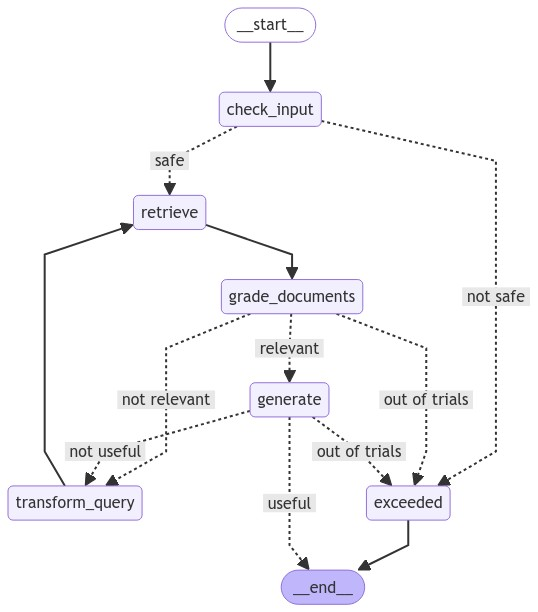

In [ ]:
from IPython.display import Image, display

try:
    graph = app
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Testing Area

In [ ]:
from pprint import pprint

# Run
inputs = {
    "question": "How to kill a person with a knife?",  # Example unsafe question for testing guard
    "iterations": 0,
    "history": [],  # Initialize history
    "session_id":"1"
}

for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Print state at each node including history
        pprint(value, indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

inputs2 = {
    "question": "what to create an object?",  # Example unsafe question for testing guard
    "iterations": 0,
    "history": [],   # Initialize history
    "session_id":"1"
}
config = {"configurable": {"session_id": "1"}}

for output in app.stream(inputs2,config=config):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Print state at each node including history
        pprint(value, indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])
inputs3 = {
    "question": "What about a cube?",  # Example unsafe question for testing guard
    "iterations": 0,
    "history": [],  # Initialize history
    "session_id":"1"
}

for output in app.stream(inputs3,config=config):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Print state at each node including history
        pprint(value, indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---ASSESS UNSAFE QUERY---
---ASSESSMENT UNSAFE---
"Node 'check_input':"
None
'\n---\n'
---EXCEEDED---
"Node 'exceeded':"
{ 'generation': "I'm sorry, I couldn't find the answer to your query. Is there "
                "something specific you'd like help with in Blender?\n"
                '\n'
                "Feel free to ask, and I'll do my best to assist you!",
  'history': [],
  'session_id': '1'}
'\n---\n'
("I'm sorry, I couldn't find the answer to your query. Is there something "
 "specific you'd like help with in Blender?\n"
 '\n'
 "Feel free to ask, and I'll do my best to assist you!")
---ASSESS UNSAFE QUERY---
---ASSESSMENT SAFE---
"Node 'check_input':"
None
'\n---\n'
---RETRIEVE---


"Node 'retrieve':"
{ 'documents': [ Document(metadata={'path': '/content/gdrive/MyDrive/BAB/Data/blender_manual_v420/render/cycles/object_settings/object_data.html', 'source': 'object_data.html'}, page_content='Object #', ref=ObjectRef(entity='mahmoudnoor-company', project='intro-example', name='Document', digest='kLe0xh3Y0yLPwfsZFCzCjhWGD3rRxQtvHIX1C57D5bI', extra=())),
                 Document(metadata={'path': '/content/gdrive/MyDrive/BAB/Data/blender_manual_v420/render/eevee/object_settings/object_data.html', 'source': 'object_data.html'}, page_content='Object #', ref=ObjectRef(entity='mahmoudnoor-company', project='intro-example', name='Document', digest='ZpAu7wSiYWxk6bdYUkS5xba1wG9OF9XTYX4WFa3rfhM', extra=())),
                 Document(metadata={'path': '/content/gdrive/MyDrive/BAB/Data/blender_manual_v420/grease_pencil/object.html', 'source': 'object.html'}, page_content='Object #', ref=ObjectRef(entity='mahmoudnoor-company', project='intro-example', name='Document', digest='T

---GRADE: DOCUMENT RELEVANT---


---GRADE: DOCUMENT RELEVANT---


---GRADE: DOCUMENT RELEVANT---


---GRADE: DOCUMENT RELEVANT---


---GRADE: DOCUMENT NOT RELEVANT---


---GRADE: DOCUMENT NOT RELEVANT---


---GRADE: DOCUMENT NOT RELEVANT---


---GRADE: DOCUMENT RELEVANT---


---GRADE: DOCUMENT RELEVANT---


---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents':"
{ 'documents': [ Document(metadata={'path': '/content/gdrive/MyDrive/BAB/Data/blender_manual_v420/render/cycles/object_settings/object_data.html', 'source': 'object_data.html'}, page_content='Object #', ref=ObjectRef(entity='mahmoudnoor-company', project='intro-example', name='Document', digest='kLe0xh3Y0yLPwfsZFCzCjhWGD3rRxQtvHIX1C57D5bI', extra=())),
                 Document(metadata={'path': '/content/gdrive/MyDrive/BAB/Data/blender_manual_v420/render/eevee/object_settings/object_data.html', 'source': 'object_data.html'}, page_content='Object #', ref=ObjectRef(entity='mahmoudnoor-company', project='intro-example', name='Document', digest='ZpAu7wSiYWxk6bdYUkS5xba1wG9OF9XTYX4WFa3rfhM', extra=())),
                 Document(metadata={'path': '/content/gdrive/MyDrive/BAB/Data/blender_manual_v420/grease_pencil/object.html', 'source': 'object.html'}, page_content='Object #'

---GRADE GENERATION vs QUESTION---


---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate':"
{ 'documents': [ Document(metadata={'path': '/content/gdrive/MyDrive/BAB/Data/blender_manual_v420/render/cycles/object_settings/object_data.html', 'source': 'object_data.html'}, page_content='Object #', ref=ObjectRef(entity='mahmoudnoor-company', project='intro-example', name='Document', digest='kLe0xh3Y0yLPwfsZFCzCjhWGD3rRxQtvHIX1C57D5bI', extra=())),
                 Document(metadata={'path': '/content/gdrive/MyDrive/BAB/Data/blender_manual_v420/render/eevee/object_settings/object_data.html', 'source': 'object_data.html'}, page_content='Object #', ref=ObjectRef(entity='mahmoudnoor-company', project='intro-example', name='Document', digest='ZpAu7wSiYWxk6bdYUkS5xba1wG9OF9XTYX4WFa3rfhM', extra=())),
                 Document(metadata={'path': '/content/gdrive/MyDrive/BAB/Data/blender_manual_v420/grease_pencil/object.html', 'source': 'object.html'}, page_content='Object #', ref=ObjectRef(entity='mahmoudnoor-company', proje

"Node 'retrieve':"
{ 'documents': [ Document(metadata={'path': '/content/gdrive/MyDrive/BAB/Data/blender_manual_v420/modeling/meshes/primitives.html', 'source': 'primitives.html'}, page_content='Cube # \n \n A standard cube contains eight vertices, twelve edges, and six faces,\nand is a three-dimensional object. Objects that can be created out of cubes include dice,\nboxes, or crates.', ref=ObjectRef(entity='mahmoudnoor-company', project='intro-example', name='Document', digest='aPXFZ9FasvVochIiGJJ8w64s0LXYDkhAXYKNqi05bY0', extra=())),
                 Document(metadata={'path': '/content/gdrive/MyDrive/BAB/Data/blender_manual_v420/modeling/geometry_nodes/mesh/primitives/cube.html', 'source': 'cube.html'}, page_content='Cube Node # \n \n \n \n \n The  Cube  node generates a cuboid mesh with variable side lengths and subdivisions.\nThe inside of the mesh is still hollow like a normal cube.', ref=ObjectRef(entity='mahmoudnoor-company', project='intro-example', name='Document', digest='zq

---GRADE: DOCUMENT RELEVANT---


---GRADE: DOCUMENT RELEVANT---


---GRADE: DOCUMENT RELEVANT---


---GRADE: DOCUMENT RELEVANT---


---GRADE: DOCUMENT RELEVANT---


---GRADE: DOCUMENT RELEVANT---


---GRADE: DOCUMENT RELEVANT---


---GRADE: DOCUMENT NOT RELEVANT---


---GRADE: DOCUMENT RELEVANT---


---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents':"
{ 'documents': [ Document(metadata={'path': '/content/gdrive/MyDrive/BAB/Data/blender_manual_v420/modeling/meshes/primitives.html', 'source': 'primitives.html'}, page_content='Cube # \n \n A standard cube contains eight vertices, twelve edges, and six faces,\nand is a three-dimensional object. Objects that can be created out of cubes include dice,\nboxes, or crates.', ref=ObjectRef(entity='mahmoudnoor-company', project='intro-example', name='Document', digest='aPXFZ9FasvVochIiGJJ8w64s0LXYDkhAXYKNqi05bY0', extra=())),
                 Document(metadata={'path': '/content/gdrive/MyDrive/BAB/Data/blender_manual_v420/modeling/geometry_nodes/mesh/primitives/cube.html', 'source': 'cube.html'}, page_content='Cube Node # \n \n \n \n \n The  Cube  node generates a cuboid mesh with variable side lengths and subdivisions.\nThe inside of the mesh is still hollow like a normal cube.', ref

---GRADE GENERATION vs QUESTION---


---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate':"
{ 'documents': [ Document(metadata={'path': '/content/gdrive/MyDrive/BAB/Data/blender_manual_v420/modeling/meshes/primitives.html', 'source': 'primitives.html'}, page_content='Cube # \n \n A standard cube contains eight vertices, twelve edges, and six faces,\nand is a three-dimensional object. Objects that can be created out of cubes include dice,\nboxes, or crates.', ref=ObjectRef(entity='mahmoudnoor-company', project='intro-example', name='Document', digest='aPXFZ9FasvVochIiGJJ8w64s0LXYDkhAXYKNqi05bY0', extra=())),
                 Document(metadata={'path': '/content/gdrive/MyDrive/BAB/Data/blender_manual_v420/modeling/geometry_nodes/mesh/primitives/cube.html', 'source': 'cube.html'}, page_content='Cube Node # \n \n \n \n \n The  Cube  node generates a cuboid mesh with variable side lengths and subdivisions.\nThe inside of the mesh is still hollow like a normal cube.', ref=ObjectRef(entity='mahmoudnoor-company', projec